# Forecasting Stock Market Volatility Using Machine Learning Models

## Problem Description

Volatility forecasting is a fundamental problem in financial economics and risk management. Volatility reflects the degree of uncertainty or risk associated with the magnitude of asset price movements and plays a crucial role in portfolio allocation, derivative pricing, and regulatory capital requirements. Accurate volatility forecasts are therefore of significant interest to investors, financial institutions, and policymakers.

In this study, we aim to forecast short-term stock market volatility using historical market data and machine learning methods. In particular, we focus on predicting next-day realized volatility of a publicly listed company based on past price dynamics and trading activity. Unlike traditional econometric models, machine learning approaches allow for flexible nonlinear relationships and can exploit a rich set of engineered features derived from market data.

Daily volatility is not directly observable. Following the financial econometrics literature, we use the absolute value of daily log returns as a proxy for realized volatility. This measure captures the magnitude of price movements regardless of direction and provides a robust volatility proxy, especially in the presence of heavy-tailed return distributions.

This task is formulated as a supervised regression problem, where the goal is to predict a continuous-valued volatility proxy.

The main objective of this project is to compare the predictive performance of different machine learning models, including boosting-based models and neural networks, in forecasting volatility in a time-series setting.

---

## Dataset Description

The dataset used in this study consists of daily historical stock market data for Citigroup Inc. (ticker: C), a major U.S. financial institution listed on the New York Stock Exchange. The data span multiple decades, starting from the late 1970s, and provide a long time horizon suitable for time-series analysis.

The data include standard OHLCV variables, which summarize daily price dynamics and trading activity:

- **Date**: Trading date.
- **Open**: Opening price of the stock.
- **High**: Highest price during the trading day.
- **Low**: Lowest price during the trading day.
- **Close**: Closing price of the stock.
- **Volume**: Number of shares traded during the day.

Additional columns such as ticker symbols and company names are included in the raw dataset but are not used for modeling purposes.

All prices are expressed in U.S. dollars, and the data are sorted chronologically to preserve the time-series structure.

---

## Target Variable Definition

The target variable in this study is next-day realized volatility, defined as the absolute value of the daily log return:

$$
\mathrm{Volatility}_{t+1} = |r_{t+1}|
$$

where:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$
and \( P_t \) denotes the closing price on day \( t \).

By shifting the target variable one day ahead, we ensure that all models are trained using only information available at time \( t \), thereby avoiding look-ahead bias.

---

## Evaluation Metrics

Since the task is formulated as a regression problem, model performance is evaluated using absolute error-based metrics:

- **Mean Absolute Error (MAE)**: Measures the average absolute prediction error in the same units as the target, making it easy to interpret and relatively robust to outliers.
- **Root Mean Square Error (RMSE)**: Renalizes large errors more heavily, highlighting model failures during high-volatility or extreme periods, which is particularly important in volatility forecasting.

These metrics allow for a consistent comparison across different model classes.

---

## Modeling Framework

The project compares four machine learning models selected from the course syllabus:

- Gradient Boosting
- Extreme Gradient Boosting (XGBoost)
- Recurrent Neutral Network(RNN)
- Long short-term memory (LSTM)

All models are trained and evaluated using a strict time-series split of the data into training, validation, and test sets. Feature engineering is performed using only historical information to preserve the causal structure of the forecasting problem.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
import joblib
import os


In [2]:
# =======================
# STEP 1: Load data, construct volatility target, and time-series split
# =======================

# 1) Load data
PATH = "Citigroup_historical_data.csv" 
df = pd.read_csv(PATH)

# 2) Parse and sort by date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 3) Keep only relevant columns
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

# 4) Compute log returns using Close price
df["log_price"] = np.log(df["Close"])
df["r_t"] = df["log_price"].diff()    

# 5) Define next-day volatility proxy as target: |r_{t+1}|
#    This ensures no look-ahead bias
df["y_vol_next"] = df["r_t"].abs().shift(-1)

# 6) Drop rows with missing values caused by diff() and shift()
df_model = df.dropna(subset=["r_t", "y_vol_next"]).copy()

# 7) Time-series split: 70% train / 15% validation / 15% test
n = len(df_model)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train = df_model.iloc[:train_end].copy()
val   = df_model.iloc[train_end:val_end].copy()
test  = df_model.iloc[val_end:].copy()

print("Rows (total / train / validation / test):", n, len(train), len(val), len(test))
print("Date ranges:")
print("  Train:", train["Date"].min().date(), "->", train["Date"].max().date())
print("  Validation:", val["Date"].min().date(), "->", val["Date"].max().date())
print("  Test:", test["Date"].min().date(), "->", test["Date"].max().date())

# 8) Sanity check
cols_to_show = ["Date", "Close", "r_t", "y_vol_next"]
print("\nHead:")
print(df_model[cols_to_show].head())

print("\nTail:")
print(df_model[cols_to_show].tail())


Rows (total / train / validation / test): 12350 8645 1852 1853
Date ranges:
  Train: 1977-01-04 -> 2011-04-06
  Validation: 2011-04-07 -> 2018-08-15
  Test: 2018-08-16 -> 2025-12-30

Head:
                        Date     Close      r_t  y_vol_next
1  1977-01-04 00:00:00-05:00  6.708708  0.00319    0.006390
2  1977-01-05 00:00:00-05:00  6.665976 -0.00639    0.006430
3  1977-01-06 00:00:00-05:00  6.623248 -0.00643    0.003220
4  1977-01-07 00:00:00-05:00  6.644610  0.00322    0.009600
5  1977-01-10 00:00:00-05:00  6.708708  0.00960    0.003179

Tail:
                            Date       Close       r_t  y_vol_next
12346  2025-12-23 00:00:00-05:00  119.400002  0.011032    0.017929
12347  2025-12-24 00:00:00-05:00  121.559998  0.017929    0.009422
12348  2025-12-26 00:00:00-05:00  120.419998 -0.009422    0.019200
12349  2025-12-29 00:00:00-05:00  118.129997 -0.019200    0.007818
12350  2025-12-30 00:00:00-05:00  117.209999 -0.007818    0.002819


C:\Users\XINYUE\AppData\Local\Temp\ipykernel_14596\1513597757.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["Date"] = pd.to_datetime(df["Date"])


## Feature Engineering

In this section, we construct a set of explanatory variables derived from historical price and volume information. All features are computed using only information available up to time t in order to avoid look-ahead bias.

The engineered features aim to capture key stylized facts of financial markets, in particular volatility clustering, intraday price dispersion, and trading activity.


In [3]:
# =======================
# STEP 2: Feature Engineering
# =======================

df_feat = df_model.copy()

# ------------------------------------------------
# 1) Lagged returns and absolute returns
# ------------------------------------------------
for lag in [1, 2, 3, 5, 10]:
    df_feat[f"r_lag_{lag}"] = df_feat["r_t"].shift(lag)
    df_feat[f"abs_r_lag_{lag}"] = df_feat["r_t"].abs().shift(lag)

# ------------------------------------------------
# 2) Rolling volatility measures
# ------------------------------------------------
for window in [5, 10, 20]:
    df_feat[f"roll_vol_{window}"] = (
        df_feat["r_t"]
        .rolling(window=window)
        .std()
    )
    
    df_feat[f"roll_abs_r_mean_{window}"] = (
        df_feat["r_t"]
        .abs()
        .rolling(window=window)
        .mean()
    )

# ------------------------------------------------
# 3) OHLC-based intraday features
# ------------------------------------------------
df_feat["hl_range"] = df_feat["High"] - df_feat["Low"]
df_feat["hl_range_pct"] = (df_feat["High"] - df_feat["Low"]) / df_feat["Close"]
df_feat["co_range"] = (df_feat["Close"] - df_feat["Open"]).abs()

# ------------------------------------------------
# 4) Volume-based features
# ------------------------------------------------
df_feat["log_volume"] = np.log(df_feat["Volume"] + 1)

df_feat["volume_change"] = df_feat["Volume"].pct_change()

for window in [5, 10, 20]:
    df_feat[f"roll_volume_mean_{window}"] = (
        df_feat["Volume"]
        .rolling(window=window)
        .mean()
    )

# ------------------------------------------------
# 5) Drop rows with NaNs created by lagging/rolling
# ------------------------------------------------
df_feat = df_feat.dropna().reset_index(drop=True)

print("Final feature matrix shape:", df_feat.shape)
print("Number of engineered features:", df_feat.shape[1] - 2)  # excluding Date and target


Final feature matrix shape: (12331, 33)
Number of engineered features: 31


## Exploratory Data Analysis (EDA)

Although feature engineering in this study is primarily guided by financial theory, a concise exploratory data analysis is conducted to visually confirm key stylized facts of financial time series. In particular, we focus on return distributions, volatility clustering, and time-varying risk dynamics, which motivate the use of machine learning models for volatility forecasting.


### Closing Price Time Series

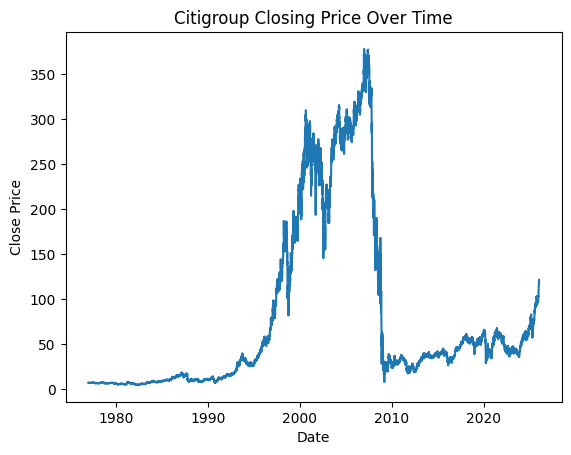

In [4]:
plt.figure()
plt.plot(df_model["Date"], df_model["Close"])
plt.title("Citigroup Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


### Distribution of Daily Log Returns

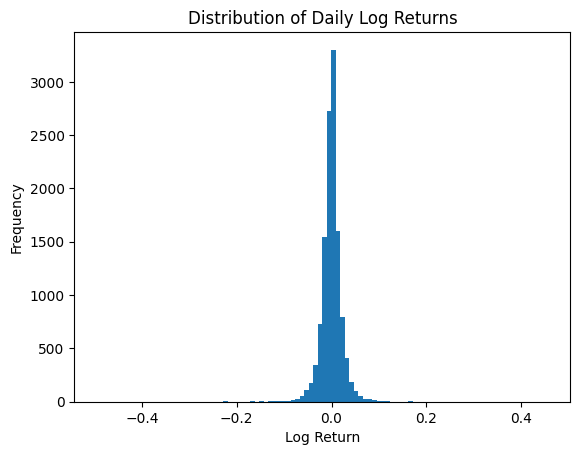

In [5]:
plt.figure()
plt.hist(df_model["r_t"], bins=100)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

The distribution of daily log returns is sharply peaked around zero, while exhibiting long and relatively dense tails on both sides. This indicates that extreme return realizations occur more frequently than would be implied by a normal distribution, providing clear evidence of heavy-tailed behavior.

### Absolute Returns (Volatility Proxy) Over Time

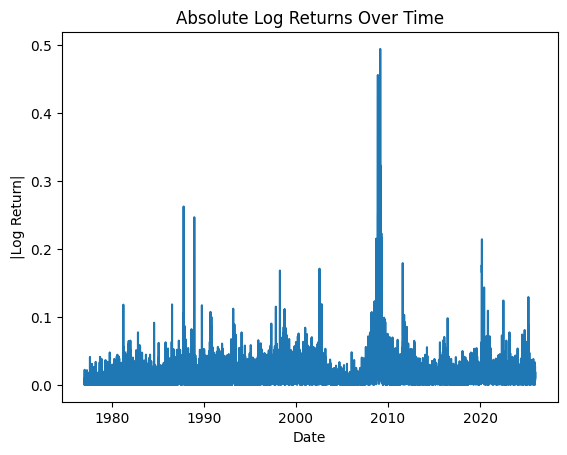

In [6]:
plt.figure()
plt.plot(df_model["Date"], df_model["r_t"].abs())
plt.title("Absolute Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("|Log Return|")
plt.show()


Absolute log returns display pronounced volatility clustering, with periods of elevated volatility followed by calmer regimes. The presence of rare but extremely large spikes further reinforces the heavy-tailed nature of return dynamics.

### Rolling Volatility (5-day and 20-day)

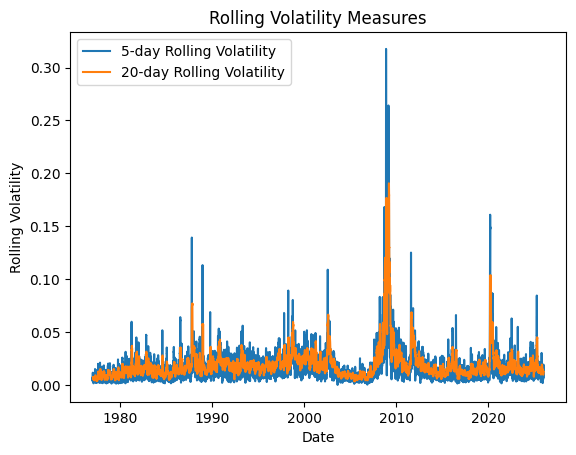

In [7]:
df_model["roll_vol_5"] = df_model["r_t"].rolling(window=5).std()
df_model["roll_vol_20"] = df_model["r_t"].rolling(window=20).std()

plt.figure()
plt.plot(df_model["Date"], df_model["roll_vol_5"], label="5-day Rolling Volatility")
plt.plot(df_model["Date"], df_model["roll_vol_20"], label="20-day Rolling Volatility")
plt.legend()
plt.title("Rolling Volatility Measures")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility")
plt.show()


Both short- and medium-horizon rolling volatility measures exhibit sharp spikes during turbulent periods, while remaining low for most of the sample. This indicates that volatility itself is heavy-tailed and strongly time-varying.

### Volume vs Absolute Returns

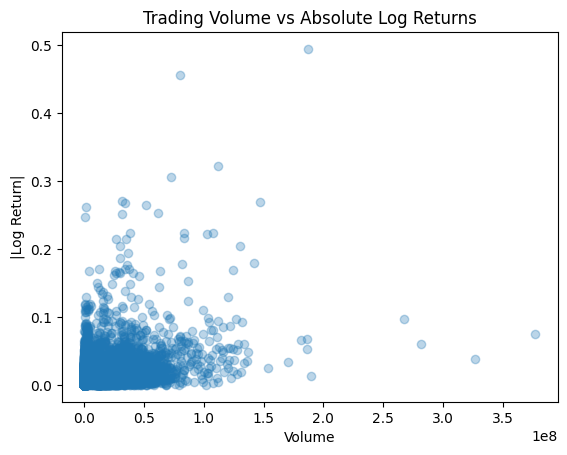

In [8]:
plt.figure()
plt.scatter(df_model["Volume"], df_model["r_t"].abs(), alpha=0.3)
plt.title("Trading Volume vs Absolute Log Returns")
plt.xlabel("Volume")
plt.ylabel("|Log Return|")
plt.show()


The scatter plot suggests that higher trading volume is associated with greater dispersion in absolute returns. Extreme volatility events tend to coincide with periods of elevated trading activity.

### Correlation Analysis

To assess linear relationships and potential redundancy among selected engineered features, a correlation heatmap is presented. This analysis helps to identify highly correlated variables and provides intuition for subsequent feature selection and model interpretation.


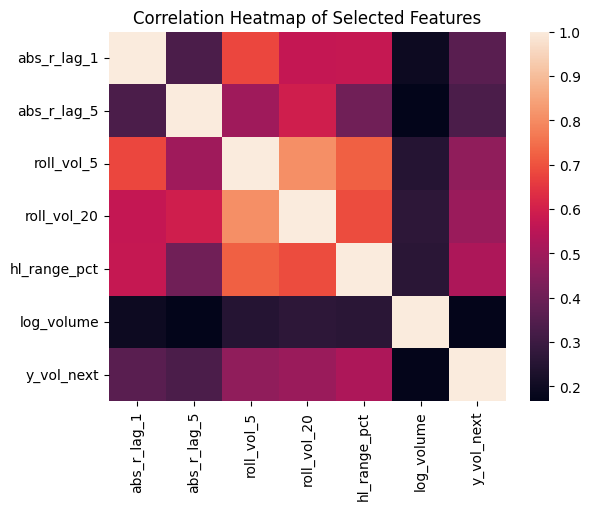

In [9]:
selected_features = [
    "abs_r_lag_1",
    "abs_r_lag_5",
    "roll_vol_5",
    "roll_vol_20",
    "hl_range_pct",
    "log_volume",
    "y_vol_next"
]

corr_matrix = df_feat[selected_features].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation Heatmap of Selected Features")
plt.show()


The correlation heatmap reveals strong linear relationships between rolling volatility measures and future volatility, while volume exhibits weaker linear correlation. This suggests that extreme volatility is driven by nonlinear dynamics rather than simple linear dependence.

The presence of long-tailed return distributions, extreme spikes in absolute returns, and sharp surges in rolling volatility collectively provide strong visual evidence of heavy-tailed behavior in financial time series. These stylized facts motivate the use of nonlinear machine learning models for volatility forecasting.

* Given the heterogeneous nature of the models considered in this study, explicit feature selection is not performed prior to model estimation. Instead, all models are trained on the same engineered feature set, while model-specific feature importance and interpretability tools are used to assess the relevance of individual predictors.


### OHLC Features EDA

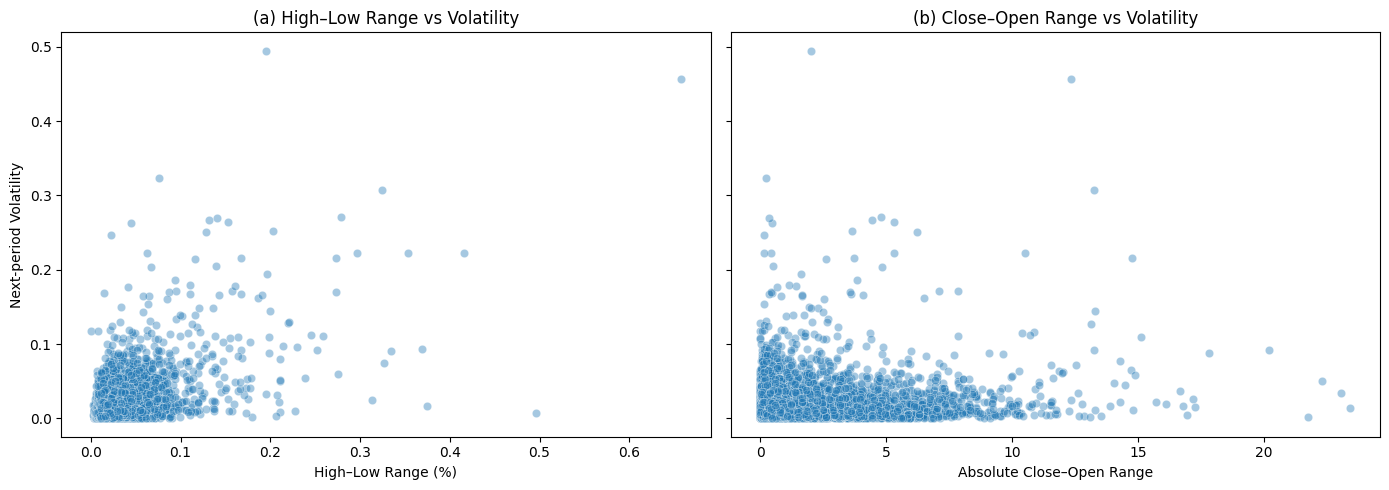

In [10]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# (a) High–Low range vs volatility
sns.scatterplot(
    data=df_feat,
    x="hl_range_pct",
    y="y_vol_next",
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_xlabel("High–Low Range (%)")
axes[0].set_ylabel("Next-period Volatility")
axes[0].set_title("(a) High–Low Range vs Volatility")

# (b) Close–Open range vs volatility
sns.scatterplot(
    data=df_feat,
    x="co_range",
    y="y_vol_next",
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_xlabel("Absolute Close–Open Range")
axes[1].set_title("(b) Close–Open Range vs Volatility")

plt.tight_layout()
plt.show()


Comparing the two plots, the high–low range shows a clearer positive relationship with next-period volatility: as the range increases, volatility tends to increase more consistently, with points more aligned along an upward pattern. 
In contrast, the close–open range is much more dispersed horizontally. Many large close–open moves are followed by both low and high volatility. The center of mass is flatter — the slope is weaker. Indicating Close–open captures directional shocks, not continuous trading variability. A weaker and noisier relationship where large moves do not translate as reliably into higher future volatility.

### Volume & Volatility Interaction

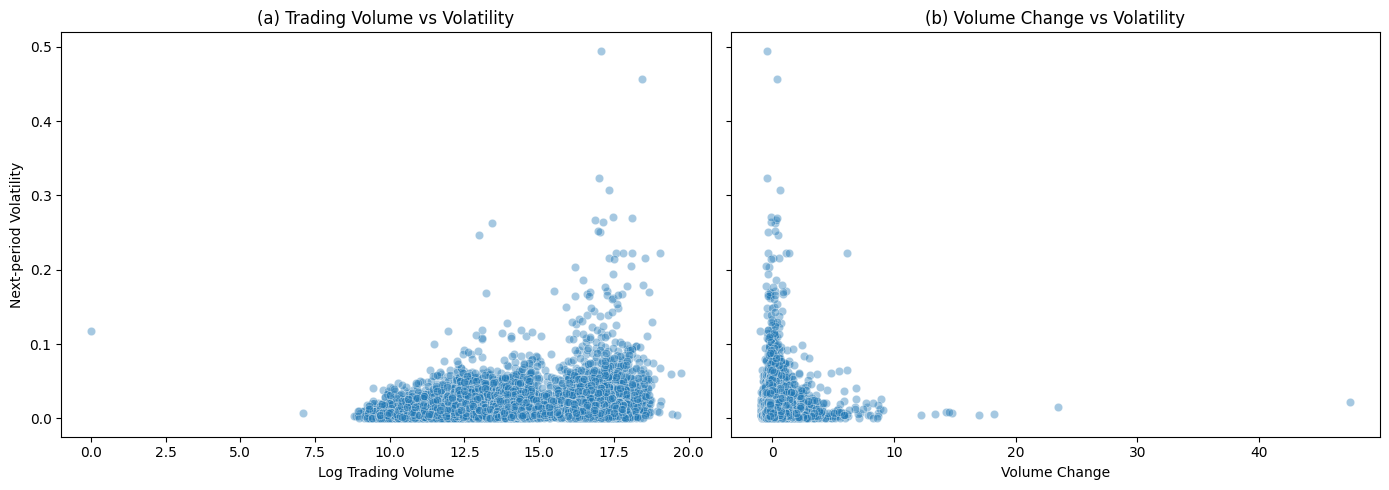

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# (a) Log volume vs volatility
sns.scatterplot(
    data=df_feat,
    x="log_volume",
    y="y_vol_next",
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_xlabel("Log Trading Volume")
axes[0].set_ylabel("Next-period Volatility")
axes[0].set_title("(a) Trading Volume vs Volatility")

# (b) Volume change vs volatility
sns.scatterplot(
    data=df_feat,
    x="volume_change",
    y="y_vol_next",
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_xlabel("Volume Change")
axes[1].set_title("(b) Volume Change vs Volatility")

plt.tight_layout()
plt.show()


Figure illustrates the relationship between trading volume variables and next-period volatility. Both log trading volume and volume changes exhibit weak and highly dispersed associations with future volatility, indicating limited explanatory power in a linear framework.

## Model 1：Gradient Boosting Regression

The first model considered in this study is a Gradient Boosting Regressor. This tree-based ensemble method is capable of capturing nonlinear relationships and interaction effects among engineered features and serves as one of the three primary forecasting models evaluated in this project.

All engineered features are used as inputs without explicit feature selection. Tree-based models are known to be robust to correlated and potentially redundant predictors, making them suitable for high-dimensional feature sets.


In [12]:
# Ensure df_feat is sorted by time
df_feat = df_feat.sort_values("Date").reset_index(drop=True)

# Time-series split (70% train / 15% validation / 15% test)
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train = df_feat.iloc[:train_end].copy()
val   = df_feat.iloc[train_end:val_end].copy()
test  = df_feat.iloc[val_end:].copy()

print("Rows (total / train / validation / test):", n, len(train), len(val), len(test))
print("Date ranges:")
print("  Train:", train["Date"].min().date(), "->", train["Date"].max().date())
print("  Validation:", val["Date"].min().date(), "->", val["Date"].max().date())
print("  Test:", test["Date"].min().date(), "->", test["Date"].max().date())

# Define feature columns from df_feat (exclude non-features)
feature_cols = [c for c in df_feat.columns if c not in ["Date", "y_vol_next"]]

# Quick check: make sure engineered features exist in each split
missing_in_train = [c for c in feature_cols if c not in train.columns]
missing_in_val = [c for c in feature_cols if c not in val.columns]
missing_in_test = [c for c in feature_cols if c not in test.columns]

print("Missing in train:", missing_in_train)
print("Missing in val  :", missing_in_val)
print("Missing in test :", missing_in_test)
print("Number of features used:", len(feature_cols))

Rows (total / train / validation / test): 12331 8631 1850 1850
Date ranges:
  Train: 1977-01-31 -> 2011-04-13
  Validation: 2011-04-14 -> 2018-08-20
  Test: 2018-08-21 -> 2025-12-30
Missing in train: []
Missing in val  : []
Missing in test : []
Number of features used: 31


In [13]:
# =======================
# Prepare X and y
# =======================

# Target variable
y_train = train["y_vol_next"]
y_val   = val["y_vol_next"]
y_test  = test["y_vol_next"]

# Features
X_train = train[feature_cols]
X_val   = val[feature_cols]
X_test  = test[feature_cols]


print("Number of features used:", len(feature_cols))


Number of features used: 31


In [14]:
# =======================
# FIX: Handle inf/-inf and extreme values in features
# =======================

def clean_features(X, clip_quantile=0.999):
    Xc = X.copy()

    # Replace inf/-inf with NaN
    Xc = Xc.replace([np.inf, -np.inf], np.nan)

    # Drop columns that are entirely NaN (rare but safe)
    all_nan_cols = Xc.columns[Xc.isna().all()].tolist()
    if all_nan_cols:
        print("Dropping all-NaN columns:", all_nan_cols)
        Xc = Xc.drop(columns=all_nan_cols)

    # Fill remaining NaNs with median (robust)
    Xc = Xc.apply(lambda s: s.fillna(s.median()), axis=0)

    # Clip extreme values (winsorization-like) to avoid overflow and stabilize training
    lower = Xc.quantile(1 - clip_quantile)
    upper = Xc.quantile(clip_quantile)
    Xc = Xc.clip(lower=lower, upper=upper, axis=1)

    return Xc

X_train_clean = clean_features(X_train, clip_quantile=0.999)
X_val_clean   = clean_features(X_val,   clip_quantile=0.999)
X_test_clean  = clean_features(X_test,  clip_quantile=0.999)

# Sanity checks
print("Any inf in train:", np.isinf(X_train_clean.to_numpy()).any())
print("Any NaN in train:", np.isnan(X_train_clean.to_numpy()).any())
print("Max abs value in train:", np.max(np.abs(X_train_clean.to_numpy())))

Any inf in train: False
Any NaN in train: False
Max abs value in train: 174511906.30000818


In [15]:
# =======================
# Train Gradient Boosting model
# =======================

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8, #ramdoness, decrease overfitting
    random_state=42
)

gbr.fit(X_train_clean, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,300
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


The Gradient Boosting Regressor is used as a baseline model with conservative hyperparameter settings. A relatively small learning rate combined with a moderate number of estimators ensures stable learning, while shallow trees and subsampling are employed to reduce overfitting. These choices are particularly suitable for time-series forecasting problems, where model robustness is preferred over excessive complexity.


#### hyperparameter tunning

In [16]:
param_grid = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4]
}

In [17]:
best_rmse = np.inf
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    model = GradientBoostingRegressor(
        **params,
        subsample=0.8,
        random_state=42
    )
    model.fit(X_train_clean, y_train)
    y_val_pred = model.predict(X_val_clean)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

print("Best parameters:", best_params)
print("Best validation RMSE:", best_rmse)


Best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200}
Best validation RMSE: 0.01300518401824273


In [18]:
def evaluate_regression(y_true, y_pred, label):
    mae_gb = mean_absolute_error(y_true, y_pred)
    rmse_gb = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE : {mae_gb:.6f}")
    print(f"{label} RMSE: {rmse_gb:.6f}")
    print("-" * 30)

In [19]:
evaluate_regression(y_test, best_model.predict(X_test_clean), "Test")

Test MAE : 0.010217
Test RMSE: 0.014908
------------------------------


The MAE of approximately 0.010 indicates that, on average, the model’s prediction error for next-day volatility is around one percentage point, which is reasonable and interpretable in practical terms.

The fact that RMSE exceeds MAE suggests the presence of occasional large prediction errors, primarily associated with periods of unusually high volatility.

This behavior is consistent with the heavy-tailed nature of financial return distributions.

#### Predicted vs Actual volatility

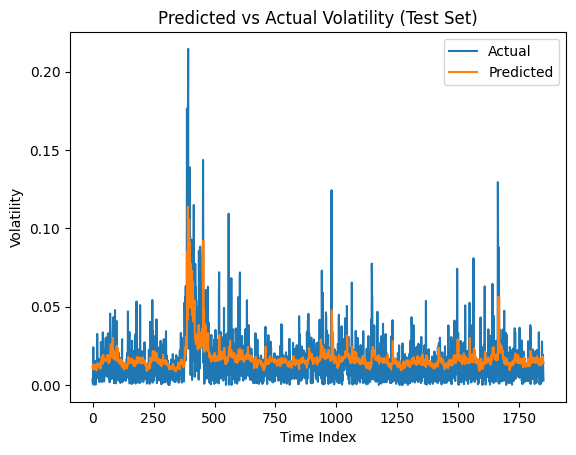

In [20]:
plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(best_model.predict(X_test_clean), label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Volatility (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Volatility")
plt.show()


The predicted volatility series closely follows the overall dynamics of the actual volatility, indicating that the model effectively captures temporal dependence in volatility.

Prediction accuracy is particularly strong during low- and medium-volatility regimes.

During extreme volatility spikes, the model systematically underestimates the true volatility, reflecting the conservative nature of tree-based models when facing rare and extreme events.

#### Residuals over time

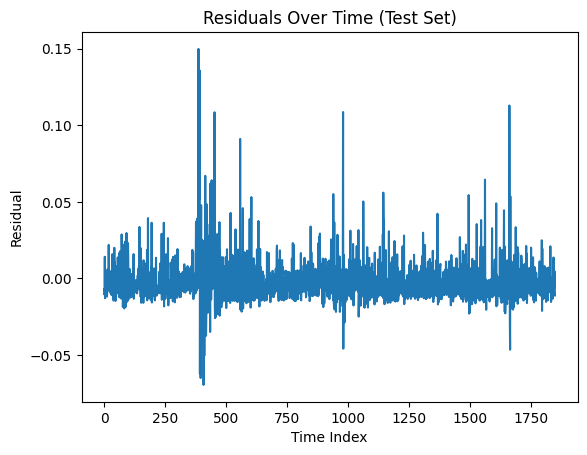

In [21]:
residuals = y_test.values - best_model.predict(X_test_clean)

plt.figure()
plt.plot(residuals)
plt.title("Residuals Over Time (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.show()


Residuals fluctuate around zero, suggesting no strong systematic bias in the model’s predictions.

Residual variance increases during turbulent periods, indicating the presence of conditional heteroskedasticity.

The temporal clustering of large residuals suggests that some dynamic patterns remain unexplained, motivating the use of more flexible models.

The Gradient Boosting model demonstrates solid predictive performance on the test set, capturing the general dynamics of stock return volatility. However, the model tends to underestimate extreme volatility spikes, which is a well-documented and expected challenge in financial volatility forecasting.

With engineered features such as rolling volatility, lagged returns, and volume-based indicators, the Gradient Boosting model provides stable volatility forecasts under normal market conditions. However, due to its tree-based structure, the model tends to smooth predictions and underestimate rare but extreme volatility events.

Overall, the Gradient Boosting model delivers robust volatility forecasts under normal market conditions and successfully captures volatility clustering. Nevertheless, its conservative response to extreme market movements results in systematic underestimation during high-volatility episodes. This limitation motivates the application of more flexible models in subsequent sections.


In [22]:
# Create directory if it does not exist
#os.makedirs("model", exist_ok=True)

# Save tuned Gradient Boosting model
joblib.dump(best_model, "model/gradient_boosting_model.joblib")

gb_model_loaded = joblib.load("model/gradient_boosting_model.joblib")

## Model 2: XGBoost Regression (with Early Stopping)

In this section, we train an Extreme Gradient Boosting (XGBoost) regressor to forecast next-day realized volatility. XGBoost is a regularized boosting algorithm that often performs strongly on tabular feature sets. We apply early stopping based on a validation set to prevent overfitting and to select the optimal number of boosting rounds.


In [26]:
def evaluate_regression(y_true, y_pred, label):
    mae_xg = mean_absolute_error(y_true, y_pred)
    rmse_xg = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE : {mae_xg:.6f}")
    print(f"{label} RMSE: {rmse_xg:.6f}")
    print("-" * 30)

In [27]:

# Build DMatrix (works across older versions)
dtrain = xgb.DMatrix(X_train_clean, label=y_train)
dval   = xgb.DMatrix(X_val_clean,   label=y_val)
dtest  = xgb.DMatrix(X_test_clean,  label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

watchlist = [(dtrain, "train"), (dval, "val")]

# Large num_boost_round + early stopping selects best iteration
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Best iteration:", booster.best_iteration)
print("Best validation RMSE:", booster.best_score)

# Predictions
y_train_pred = booster.predict(dtrain, iteration_range=(0, booster.best_iteration + 1))
y_val_pred   = booster.predict(dval,   iteration_range=(0, booster.best_iteration + 1))
y_test_pred_xg  = booster.predict(dtest,  iteration_range=(0, booster.best_iteration + 1))


Best iteration: 75
Best validation RMSE: 0.01286343146303435


Using early stopping on the validation set, the XGBoost model selects an optimal number of 67 boosting rounds, effectively controlling model complexity. Test-set MAE and RMSE are very close to those obtained from the Gradient Boosting model, indicating that both tree-based methods capture the main volatility dynamics given the current feature set.

In [28]:
evaluate_regression(y_train, y_train_pred, "Train")
evaluate_regression(y_val,   y_val_pred,   "Validation")
evaluate_regression(y_test,  y_test_pred_xg,  "Test")


Train MAE : 0.009798
Train RMSE: 0.015228
------------------------------
Validation MAE : 0.009251
Validation RMSE: 0.012863
------------------------------
Test MAE : 0.009882
Test RMSE: 0.014850
------------------------------


Training, validation, and test errors are very similar, suggesting no severe overfitting or underfitting. 

The slightly higher RMSE on the test set compared to validation indicates mild degradation in out-of-sample performance, while the gap between RMSE and MAE reflects the presence of occasional large prediction errors.

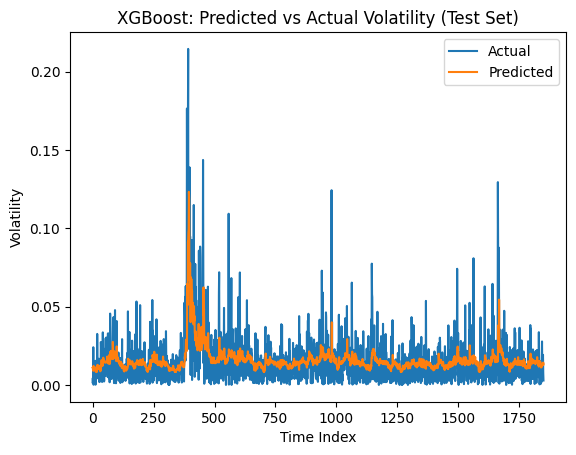

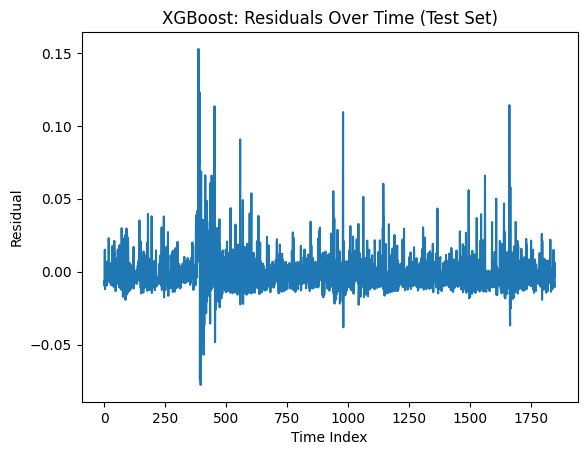

In [29]:

plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(y_test_pred_xg, label="Predicted")
plt.legend()
plt.title("XGBoost: Predicted vs Actual Volatility (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Volatility")
plt.show()

residuals = y_test.values - y_test_pred_xg
plt.figure()
plt.plot(residuals)
plt.title("XGBoost: Residuals Over Time (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.show()


Predicted volatility closely tracks the actual series over most periods, particularly during low- and medium-volatility regimes. Nonetheless, the model continues to underestimate sharp volatility spikes, indicating that even a more flexible boosting model remains conservative when forecasting rare extreme events.

Residuals fluctuate around zero, suggesting no strong systematic bias. However, residual variance increases during turbulent periods, indicating that prediction errors are larger when volatility is elevated, consistent with conditional heteroskedasticity in financial time series.

* The XGBoost model, equipped with early stopping, provides stable and well-regularized volatility forecasts. While it slightly improves validation performance relative to Gradient Boosting, test-set results remain comparable, indicating that further gains may require models that explicitly exploit sequential dependencies.


* For the XGBoost model, no exhaustive hyperparameter search is conducted. Instead, model complexity is controlled via early stopping on a validation set, which automatically determines the optimal number of boosting rounds and prevents overfitting.
* This approach provides a good balance between computational efficiency and robust model regularization.


In [30]:
booster.save_model("model/xgboost_volatility_model.json")

loaded_booster = xgb.Booster()
loaded_booster.load_model("model/xgboost_volatility_model.json")

## Model 3: Recurrent Neural Network (RNN)

Recurrent Neural Networks (RNNs) are employed to model the temporal dependence and persistence commonly observed in financial market volatility. URNNs process sequential inputs by retaining information from previous periods through a recurrent hidden state, allowing the model to capture short-term volatility dynamics.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled   = scaler.transform(X_val_clean)
X_test_scaled  = scaler.transform(X_test_clean)

# Convert tabular data → sequences

def make_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y.iloc[i])
    return np.array(X_seq), np.array(y_seq)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define RNN model builder (for tuning)
def build_rnn_model(
    seq_len,
    n_features,
    n_units=64,
    dropout=0.2,
    learning_rate=0.001
):
    model = Sequential([
        SimpleRNN(
            n_units,
            activation="tanh",
            input_shape=(seq_len, n_features)
        ),
        Dropout(dropout),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mse"
    )
    return model


In [34]:
# Hyperparameter grid
SEQ_LEN_GRID = [10, 20, 30]
UNITS_GRID   = [32, 64]
DROPOUT_GRID = [0.1, 0.2, 0.3]
LR_GRID      = [0.001, 0.0005]
EPOCHS = 30
BATCH_SIZE = 32

In [35]:
results = []

for seq_len in SEQ_LEN_GRID:
    # Build sequences
    X_tr_seq, y_tr_seq = make_sequences(X_train_scaled, y_train, seq_len)
    X_va_seq, y_va_seq = make_sequences(X_val_scaled,   y_val,   seq_len)
    
    n_features = X_tr_seq.shape[2]
    
    for units in UNITS_GRID:
        for dropout in DROPOUT_GRID:
            for lr in LR_GRID:
                
                model = build_rnn_model(
                    seq_len=seq_len,
                    n_features=n_features,
                    n_units=units,
                    dropout=dropout,
                    learning_rate=lr
                )
                
                model.fit(
                    X_tr_seq, y_tr_seq,
                    validation_data=(X_va_seq, y_va_seq),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0
                )
                
                # Validation predictions
                y_val_pred = model.predict(X_va_seq).ravel()
                
                # Metrics
                rmse = np.sqrt(mean_squared_error(y_va_seq, y_val_pred))
                mae  = mean_absolute_error(y_va_seq, y_val_pred)
                
                results.append({
                    "seq_len": seq_len,
                    "units": units,
                    "dropout": dropout,
                    "lr": lr,
                    "val_rmse": rmse,
                    "val_mae": mae
                })


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [36]:
results

[{'seq_len': 10,
  'units': 32,
  'dropout': 0.1,
  'lr': 0.001,
  'val_rmse': np.float64(0.013597800978336811),
  'val_mae': 0.009977253795015706},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.1,
  'lr': 0.0005,
  'val_rmse': np.float64(0.014406488469309598),
  'val_mae': 0.009413008490460175},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.2,
  'lr': 0.001,
  'val_rmse': np.float64(0.014165153928096945),
  'val_mae': 0.009305820225639473},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.2,
  'lr': 0.0005,
  'val_rmse': np.float64(0.01490445549869525),
  'val_mae': 0.01149559046698556},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.3,
  'lr': 0.001,
  'val_rmse': np.float64(0.014056159691520251),
  'val_mae': 0.010083110490885623},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.3,
  'lr': 0.0005,
  'val_rmse': np.float64(0.015359713722695265),
  'val_mae': 0.012631766971795744},
 {'seq_len': 10,
  'units': 64,
  'dropout': 0.1,
  'lr': 0.001,
  'val_rmse': np.float64(0.0160008442278

In [37]:
best_params = (
    pd.DataFrame(results)
    .sort_values("val_rmse")
    .iloc[0]
)

In [38]:
BEST_SEQ = int(best_params["seq_len"])
BEST_UNITS = int(best_params["units"])
BEST_DROPOUT = best_params["dropout"]
BEST_LR = best_params["lr"]

# Rebuild sequences
X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = pd.concat([y_train, y_val]).reset_index(drop=True)

X_trval_seq, y_trval_seq = make_sequences(X_trainval, y_trainval, BEST_SEQ)
X_te_seq, y_te_seq       = make_sequences(X_test_scaled, y_test, BEST_SEQ)

final_rnn = build_rnn_model(
    seq_len=BEST_SEQ,
    n_features=X_trval_seq.shape[2],
    n_units=BEST_UNITS,
    dropout=BEST_DROPOUT,
    learning_rate=BEST_LR
)

final_rnn.fit(
    X_trval_seq, y_trval_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict on test set
y_test_pred = final_rnn.predict(X_te_seq).ravel()

# Metrics
test_rmse_rnn = np.sqrt(mean_squared_error(y_te_seq, y_test_pred))
test_mae_rnn  = mean_absolute_error(y_te_seq, y_test_pred)

print(f"Final RNN Test RMSE: {test_rmse_rnn:.6f}")
print(f"Final RNN Test MAE : {test_mae_rnn:.6f}")

Epoch 1/30


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2759
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0969
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0448
Epoch 4/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111
Epoch 6/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026
Epoch 8/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 9/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3895e-04
Epoch 10/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8656e-04
Epoch 11/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9122e-04
Epoch 12/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6208e-04
Epoch 13/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5689e-04
Epoch 14/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5885e-04
Epoch 15/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [39]:
# Save entire model (architecture + weights + optimizer state)
final_rnn.save("model/best_rnn_model.keras")

from keras.models import load_model
final_rnn = load_model("model/best_rnn_model.keras")

## Model 4: Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks extend standard recurrent neural networks by introducing gating mechanisms that regulate the flow of information through time, allowing the model to retain relevant past information while discarding noise. This structure mitigates the vanishing gradient problem and enables the LSTM to capture long-range dependence in volatility dynamics more effectively than a vanilla RNN.

In this study, the LSTM is applied to rolling sequences of engineered financial features to predict next-period volatility, providing a more flexible representation of persistent and regime-dependent volatility behavior.

In [40]:
# LSTM model builder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm_model(
    seq_len,
    n_features,
    n_units=64,
    dropout=0.2,
    learning_rate=0.001
):
    model = Sequential([
        LSTM(
            n_units,
            activation="tanh",
            return_sequences=False,
            input_shape=(seq_len, n_features)
        ),
        Dropout(dropout),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mse"
    )
    return model


In [41]:
# Hyperparameter grid
SEQ_LEN_GRID = [10, 20, 30]
UNITS_GRID   = [32, 64]
DROPOUT_GRID = [0.1, 0.2, 0.3]
LR_GRID      = [0.001, 0.0005]
EPOCHS = 30
BATCH_SIZE = 32

In [42]:
# Hyperparameter tuning loop (LSTM)
lstm_results = []

for seq_len in SEQ_LEN_GRID:
    # Build sequences
    X_tr_seq, y_tr_seq = make_sequences(X_train_scaled, y_train, seq_len)
    X_va_seq, y_va_seq = make_sequences(X_val_scaled,   y_val,   seq_len)
    
    n_features = X_tr_seq.shape[2]
    
    for units in UNITS_GRID:
        for dropout in DROPOUT_GRID:
            for lr in LR_GRID:
                
                model = build_lstm_model(
                    seq_len=seq_len,
                    n_features=n_features,
                    n_units=units,
                    dropout=dropout,
                    learning_rate=lr
                )
                
                model.fit(
                    X_tr_seq, y_tr_seq,
                    validation_data=(X_va_seq, y_va_seq),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0
                )
                
                # Validation predictions
                y_val_pred = model.predict(X_va_seq).ravel()
                
                rmse = np.sqrt(mean_squared_error(y_va_seq, y_val_pred))
                mae  = mean_absolute_error(y_va_seq, y_val_pred)
                
                lstm_results.append({
                    "seq_len": seq_len,
                    "units": units,
                    "dropout": dropout,
                    "lr": lr,
                    "val_rmse": rmse,
                    "val_mae": mae
                })

C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [43]:
lstm_results

[{'seq_len': 10,
  'units': 32,
  'dropout': 0.1,
  'lr': 0.001,
  'val_rmse': np.float64(0.017900233745352493),
  'val_mae': 0.01519125862217125},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.1,
  'lr': 0.0005,
  'val_rmse': np.float64(0.014290014729969883),
  'val_mae': 0.010828527595443704},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.2,
  'lr': 0.001,
  'val_rmse': np.float64(0.01397525702470804),
  'val_mae': 0.010862658804295718},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.2,
  'lr': 0.0005,
  'val_rmse': np.float64(0.013715967397293083),
  'val_mae': 0.010099134523671742},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.3,
  'lr': 0.001,
  'val_rmse': np.float64(0.01432970334621635),
  'val_mae': 0.010655222381763677},
 {'seq_len': 10,
  'units': 32,
  'dropout': 0.3,
  'lr': 0.0005,
  'val_rmse': np.float64(0.01350194973544675),
  'val_mae': 0.009614208554604407},
 {'seq_len': 10,
  'units': 64,
  'dropout': 0.1,
  'lr': 0.001,
  'val_rmse': np.float64(0.014361610755380

In [44]:
# Select best LSTM configuration
lstm_results_df = pd.DataFrame(lstm_results)

best_lstm = lstm_results_df.sort_values("val_rmse").iloc[0]
print("Best LSTM parameters:")
print(best_lstm)

Best LSTM parameters:
seq_len     30.000000
units       32.000000
dropout      0.300000
lr           0.001000
val_rmse     0.013059
val_mae      0.009053
Name: 28, dtype: float64


In [45]:
BEST_SEQ = int(best_lstm["seq_len"])
BEST_UNITS = int(best_lstm["units"])
BEST_DROPOUT = best_lstm["dropout"]
BEST_LR = best_lstm["lr"]

# Combine train + validation
X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = pd.concat([y_train, y_val]).reset_index(drop=True)

X_trval_seq, y_trval_seq = make_sequences(X_trainval, y_trainval, BEST_SEQ)
X_te_seq, y_te_seq       = make_sequences(X_test_scaled, y_test, BEST_SEQ)

final_lstm = build_lstm_model(
    seq_len=BEST_SEQ,
    n_features=X_trval_seq.shape[2],
    n_units=BEST_UNITS,
    dropout=BEST_DROPOUT,
    learning_rate=BEST_LR
)

final_lstm.fit(
    X_trval_seq, y_trval_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
y_test_pred_lstm = final_lstm.predict(X_te_seq).ravel()

test_rmse_lstm = np.sqrt(mean_squared_error(y_te_seq, y_test_pred_lstm))
test_mae_lstm  = mean_absolute_error(y_te_seq, y_test_pred_lstm)

print(f"Final LSTM Test RMSE: {test_rmse_lstm:.6f}")
print(f"Final LSTM Test MAE : {test_mae_lstm:.6f}")

Epoch 1/30


C:\Users\XINYUE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0297
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0046
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0021
Epoch 4/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5747e-04
Epoch 6/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.5782e-04
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.3949e-04
Epoch 8/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.9212e-04
Epoch 9/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.5859e-04
Epoch 10/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.3658e-04
Epoch 11/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1676e-04
Epoch 12/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.1485e-04
Epoch 13/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1419e-04
Epoch 14/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.0451e-04
Epoch 15/30
327/327 ━━━━━━━━

In [46]:
# Save entire model (architecture + weights + optimizer state)
final_lstm.save("model/best_lstm_model.keras")

from keras.models import load_model
final_lstm = load_model("model/best_lstm_model.keras")

## Model Comparison

In [48]:
y_test_pred_gb = best_model.predict(X_test_clean)

In [49]:

mae_gb  = mean_absolute_error(y_test, y_test_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))

print("GB Test MAE:", mae_gb)
print("GB Test RMSE:", rmse_gb)

GB Test MAE: 0.010217291717243896
GB Test RMSE: 0.01490810931556023


In [50]:
y_test_pred_xgb = booster.predict(dtest)

In [53]:
y_test_pred_rnn = np.asarray(y_test_pred).reshape(-1)
y_test_pred_lstm = np.asarray(y_test_pred_lstm).reshape(-1)


In [56]:

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


preds_raw = {
    "Gradient Boosting": np.asarray(y_test_pred_gb).reshape(-1),
    "XGBoost": np.asarray(y_test_pred_xgb).reshape(-1),
    "RNN": np.asarray(y_test_pred_rnn).reshape(-1),
    "LSTM": np.asarray(y_test_pred_lstm).reshape(-1)
}

min_len = min(len(v) for v in preds_raw.values())
y_true = np.asarray(y_test).reshape(-1)

# Align y_true to the same last min_len points
y_true_aligned = y_true[-min_len:]

# Align each model prediction to last min_len points
preds_aligned = {}
for name, pred in preds_raw.items():
    preds_aligned[name] = pred[-min_len:]

print("Aligned evaluation length:", min_len)
for name in preds_aligned:
    print(name, len(preds_aligned[name]))

# =======================
# Build results table
# =======================
rows = []
for model_name, y_pred in preds_aligned.items():
    mae, rmse = compute_metrics(y_true_aligned, y_pred)
    rows.append({"Model": model_name, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)

best_rmse = results_df.loc[0, "RMSE"]
worst_rmse = results_df["RMSE"].max()
results_df["RMSE_vs_best_%"] = (results_df["RMSE"] / best_rmse - 1.0) * 100.0
results_df["RMSE_improve_vs_worst_%"] = (1.0 - results_df["RMSE"] / worst_rmse) * 100.0

display(results_df.style.format({
    "MAE": "{:.6f}",
    "RMSE": "{:.6f}",
    "RMSE_vs_best_%": "{:+.2f}%",
    "RMSE_improve_vs_worst_%": "{:+.2f}%"
}))


Aligned evaluation length: 1820
Gradient Boosting 1820
XGBoost 1820
RNN 1820
LSTM 1820


,Model,MAE,RMSE,RMSE_vs_best_%,RMSE_improve_vs_worst_%
0,XGBoost,0.009942,0.014972,+0.00%,+3.47%
1,Gradient Boosting,0.010261,0.014990,+0.12%,+3.36%
2,RNN,0.009771,0.015411,+2.93%,+0.64%
3,LSTM,0.010240,0.015511,+3.60%,+0.00%


* XGBoost achieves the lowest test RMSE, closely followed by Gradient Boosting. Both tree-based models outperform RNN and LSTM, although the performance differences are relatively small.
* RNN achieves the lowest MAE, indicating slightly better average accuracy for typical volatility levels.

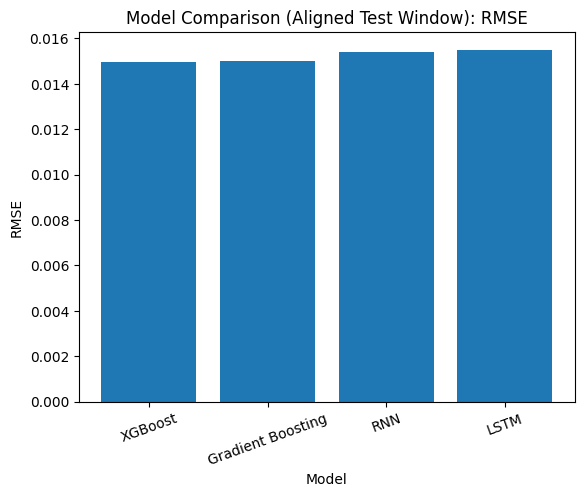

In [57]:
# Plot A: RMSE bar chart
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.title("Model Comparison (Aligned Test Window): RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=20)
plt.show()

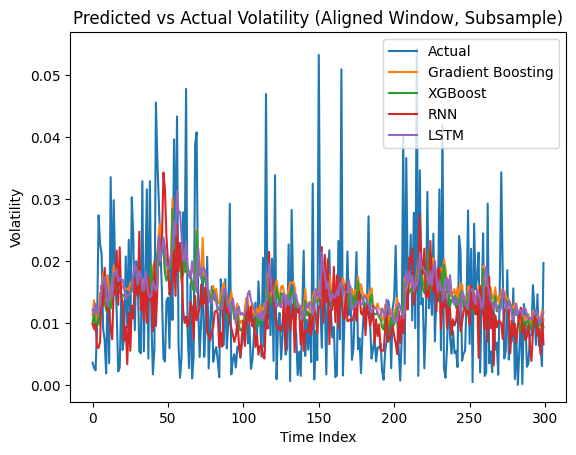

In [58]:
# Plot B: Predicted vs Actual (zoomed window)
start = 0
end = min(300, min_len)

plt.figure()
plt.plot(y_true_aligned[start:end], label="Actual")

for model_name, y_pred Sin preds_aligned.items():
    plt.plot(y_pred[start:end], label=model_name)

plt.title("Predicted vs Actual Volatility (Aligned Window, Subsample)")
plt.xlabel("Time Index")
plt.ylabel("Volatility")
plt.legend()
plt.show()